In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from golf_utils import *

# data_folder = "/disk2/data/hologolf/putting/"
data_folder = 'sample_data'

fold_to_jpgs = {}
subjects = os.listdir(data_folder)
n_jpgs = 0
for w in os.walk(data_folder):
    fold, subfolds, files = w
    if len(files) > 0 and files[0].endswith('JPG'):
        fold_to_jpgs[fold] = files
        n_jpgs += len(files)
print(f'there were {n_jpgs} jpgs')

there were 49 jpgs


In [2]:
%matplotlib widget

import cv2
import ipywidgets as widgets
from wand.image import Image as WandImage

fold, jpgs = list(fold_to_jpgs.items())[0]
jp = jpgs[5]
img = cv2.imread(os.path.join(fold, jp))
print(fold, jp)
h, w, c = img.shape
print(h,w,c)

@widgets.interact(barr0=(-2, 2, 0.1), barr1=(-2, 2, 0.1), A=(-1,1,.1), B=(-1,1,.1), rot=(-90.,90.), shift_y=(-200, 200), shift_x=(-200, 200))
def render(barr0=-.29, barr1=1.2, A=0.01, B=0.0, rot=1., shift_y=13, shift_x=-26):
    h_mid = h//2 + shift_y
    w_mid = w//2 + shift_x
    image_center = tuple([w_mid, h_mid])
    rot_mat = cv2.getRotationMatrix2D(image_center, rot, 1.0)
    img_rot = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    img_wand = WandImage.from_array(img_rot)
    img_wand.distort('barrel', (A, B, barr0, barr1, w_mid, h_mid))

    plt.imshow(img_wand)
    plt.hlines(y_grid_corrected, 0, w)
    plt.vlines(x_grid_corrected, 0, h)

sample_data/P22/Pre GP__3189.JPG
480 640 3


interactive(children=(FloatSlider(value=-0.29, description='barr0', max=2.0, min=-2.0), FloatSlider(value=1.2,…

correct ratio 1.4362745098039216
img ratio 1.4355555555555557
1m = 218.10691277742993 pixel


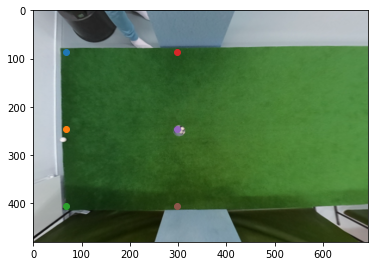

In [3]:
%matplotlib inline

print('correct ratio', correct_ratio)
print('img ratio', xdiff / ydiff)
print(f'1m = {1/pix_to_m} pixel')

plt.figure(figsize=(6,6))
img_straight = undistort_fixed(img)

plt.imshow(img_straight)

for x in x_grid_corrected:
    for y in y_grid_corrected:
        plt.scatter(x, y)

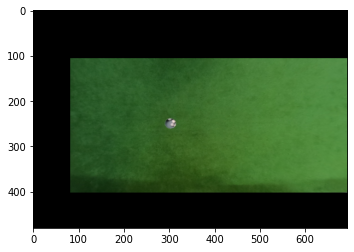

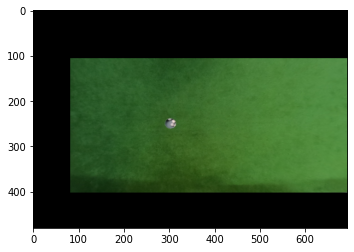

In [4]:
j = 0
i = 5

fold, jpgs = list(fold_to_jpgs.items())[j]
img_name = os.path.join(fold, jpgs[i])
img = cv2.imread(img_name)
img_straight = undistort_fixed(img)
img = filter_img_by_green(img_straight)

plt.imshow(img_straight)
plt.figure()
plt.imshow(img)

cc2: 3 [0 1 2]
0.0 10.63014581273465


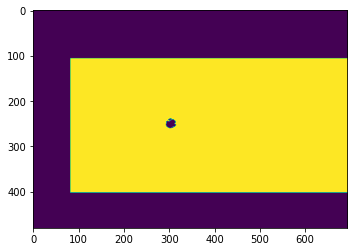

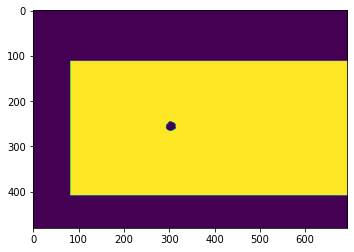

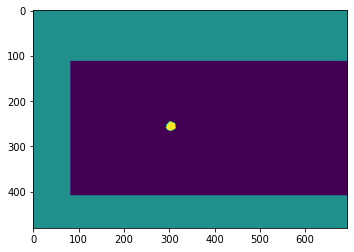

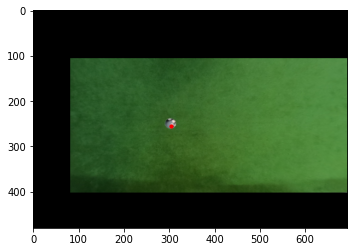

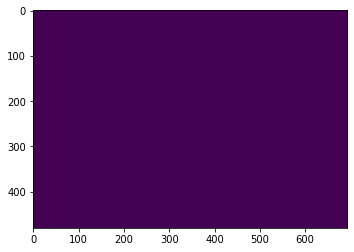

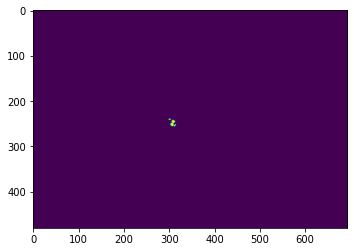

In [5]:
fold, jpgs = list(fold_to_jpgs.items())[j]
img_name = os.path.join(fold, jpgs[i])
#img_name = '/disk2/data/hologolf/putting/P07_QE - Retention nicht durchgeführt/PRÄ_Fotos/GP__1608.JPG'
img = cv2.imread(img_name)
img = undistort_fixed(img)
img = filter_img_by_green(img)
find_circles_in_img_no_hough(img, plot_it=True)

img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
blue, white = find_cards(img_col, plot_it=True)

print(blue, white)

(1, 1, 3)


array([[304, 256,  27]], dtype=uint16)

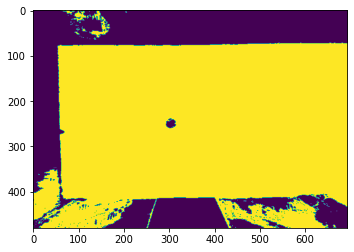

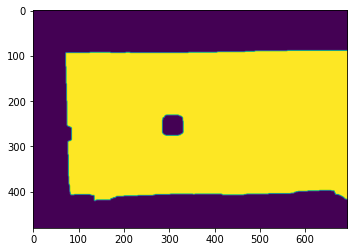

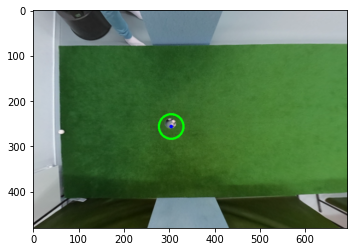

In [6]:
fold, jpgs = list(fold_to_jpgs.items())[0]
img = cv2.imread(os.path.join(fold, jpgs[5]))
img_straight = undistort_fixed(img)
find_circles_in_img(img_straight, plot_it=True)

  0%|          | 0/5 [00:00<?, ?it/s]

result_jpgs/P22_Pre_j=0.png
[0.9378461123035574, 0.8144375535244414, 0.7978924713177152, 0.18505085348906344, 0.49248821814501736, 0.5612533290997259] 0.5612533290997259


 20%|██        | 1/5 [00:02<00:11,  2.92s/it]

result_jpgs/P22_Post_j=1.png


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

result_jpgs/P22_Transfer4m_j=2.png


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

result_jpgs/P22_Tranfer2m_j=3.png


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

result_jpgs/P22_Retention_j=4.png


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


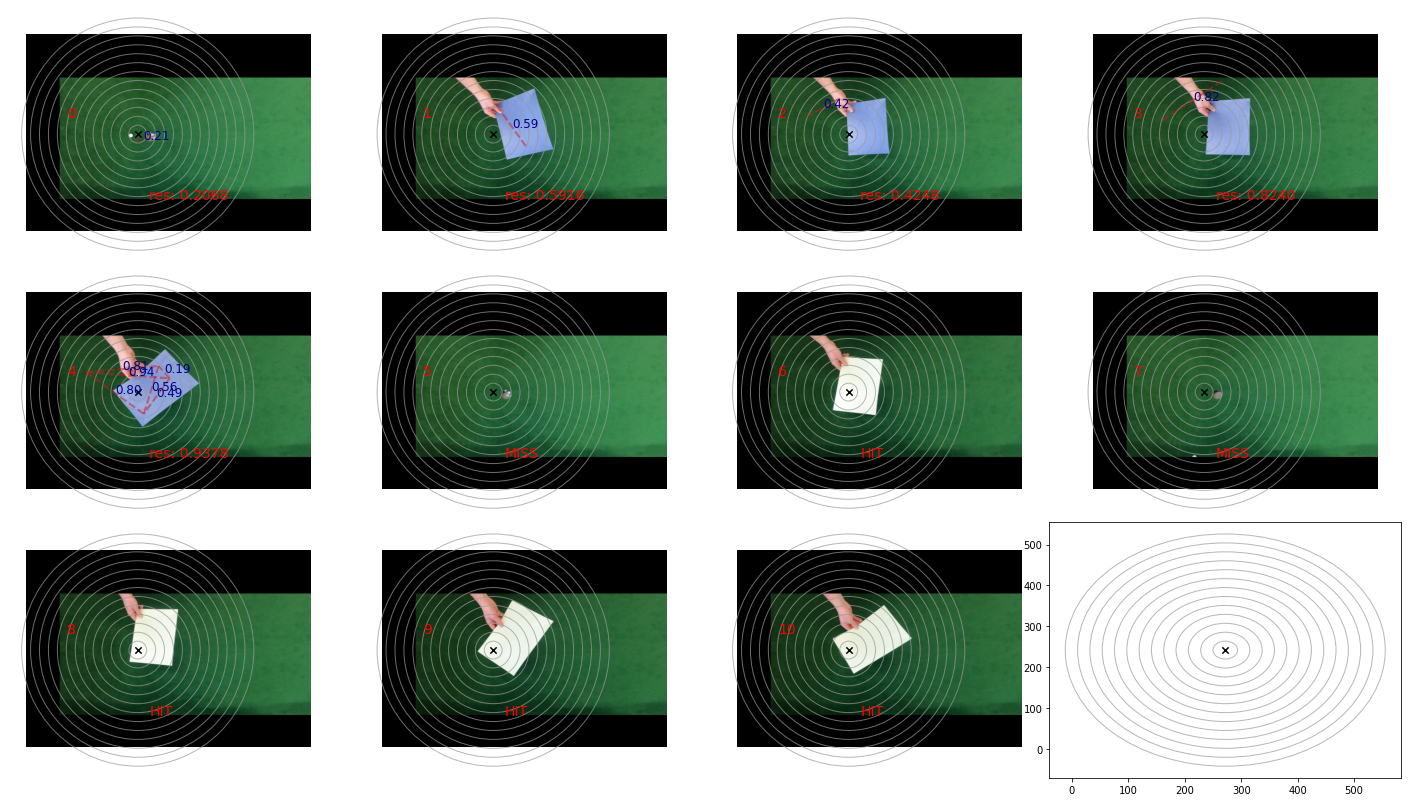

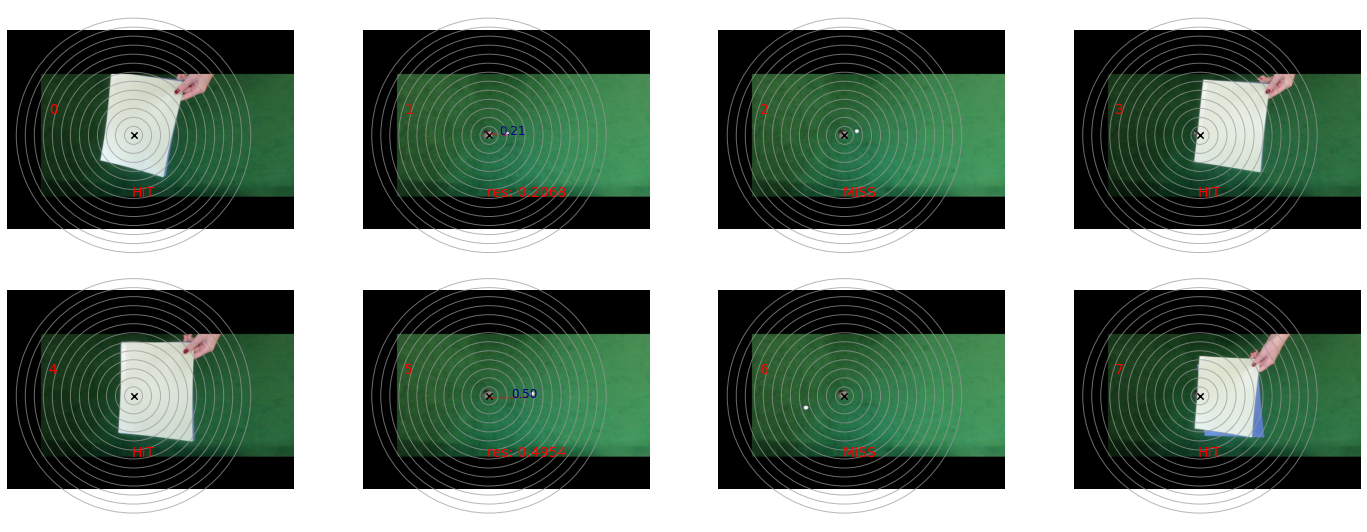

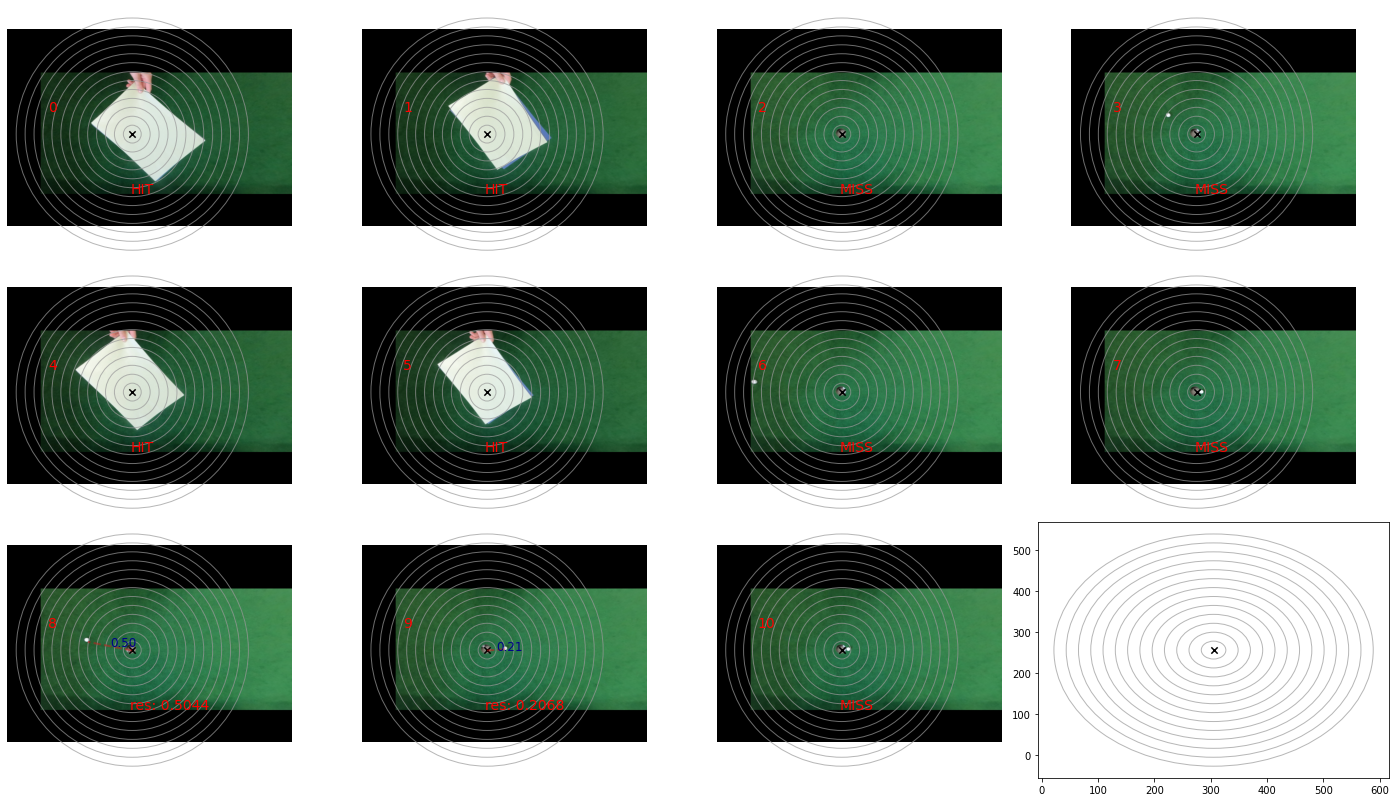

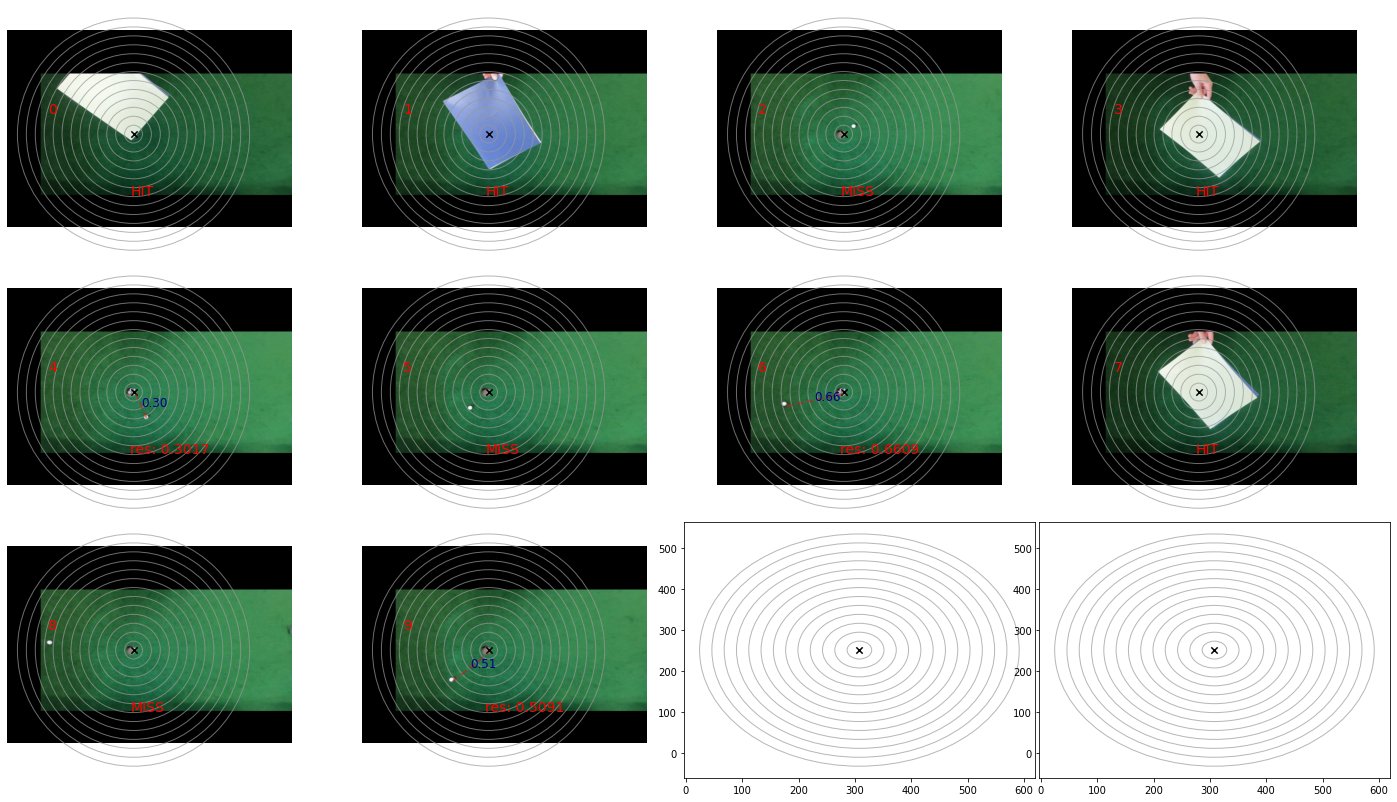

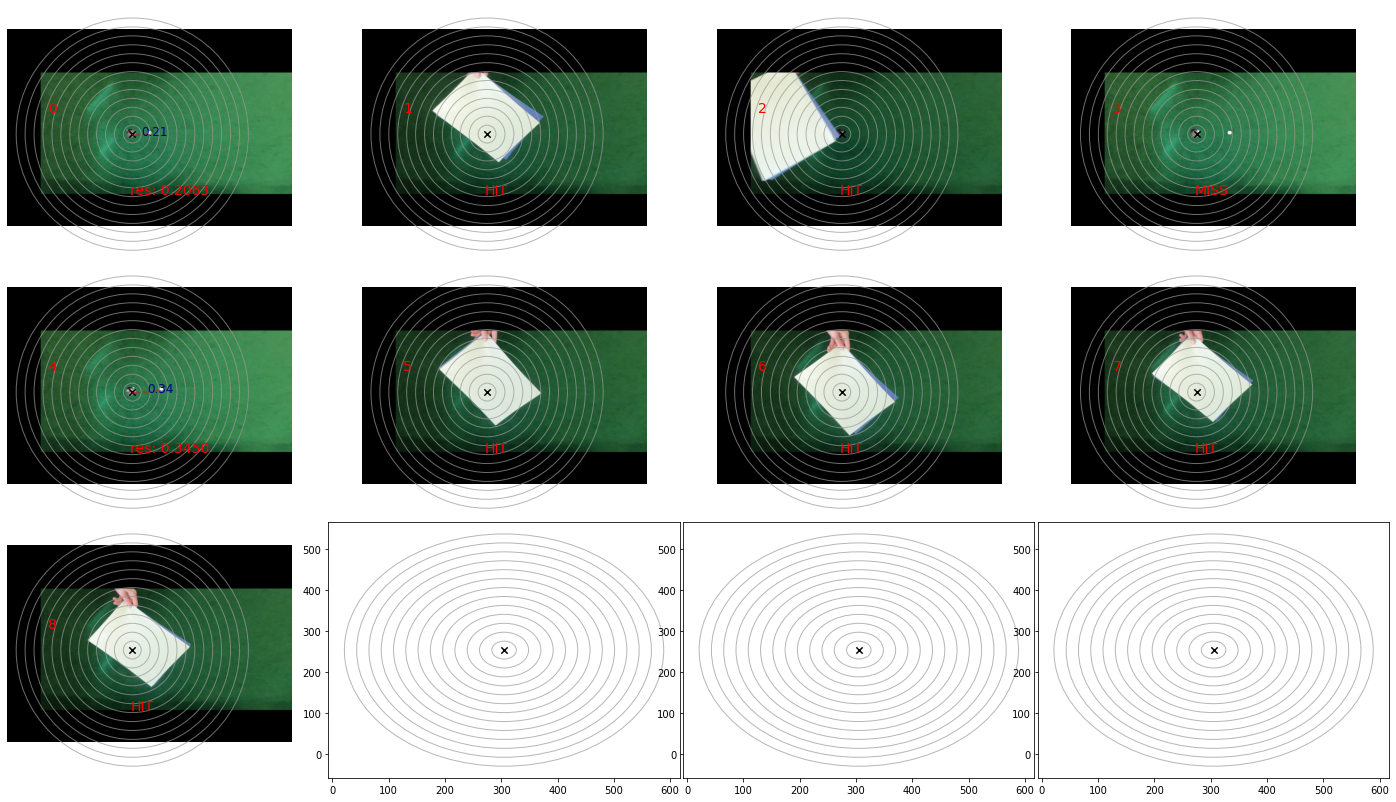

In [8]:
from tqdm import tqdm
from collections import defaultdict

asp_rat = img.shape[1] / img.shape[0]

ncols = 4

# size of filter for agglomerating center hole
wd = 20
# distance of circles: .1m
d = .1/pix_to_m

id_to_res = defaultdict(list)

for j in tqdm(range(len(fold_to_jpgs))):
    fold, jpgs = list(fold_to_jpgs.items())[j]    
            
    rname = key_to_res_name(fold)

    res_name = os.path.join('result_jpgs', rname + '_j=%d.png'%j)
    res_name_txt = os.path.join('result_txts', rname + '_j=%d.txt'%j)
    N = len(jpgs)
    nrows = int(np.ceil(N / ncols))

    print(res_name)
    if os.path.exists(res_name):
        continue

    fold_res = []
    # find the overall center of the hole and draw circles in there.
    all_circs = []

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5/asp_rat))
    fig.patch.set_facecolor('white')
    for i, jp in enumerate(jpgs):
        a = i//ncols
        b = i%ncols
        ax = axs[a,b]

        img_name = os.path.join(fold, jp)
        img = cv2.imread(img_name)
        img_straight = undistort_fixed(img)
        img_straight_filt = filter_img_by_green(img_straight)

        img_col_orig = cv2.cvtColor(img_straight, cv2.COLOR_BGR2RGB)
        img_col = cv2.cvtColor(img_straight_filt, cv2.COLOR_BGR2RGB)
        blue, white = find_cards(img_col)

        ax.imshow(img_col_orig)

        if blue > 200:
            res = -1
        elif white > 100 and n_circs<2 or white > 150:
            res = 0
        else:
            circs = find_circles_in_img(img_straight_filt)
            if circs is None:
                n_circs = 0
            else:
                n_circs = circs.shape[0]

            if n_circs > 2:
                circs2 = find_circles_in_img_no_hough(img_straight_filt)
                if len(circs2) == 2:
                    circs = circs2
                    n_circs = len(circs2)

            all_circs.append(circs)

            dists = []
            for i_c0 in range(n_circs):
                for i_c1 in range(n_circs):
                    if i_c0 >= i_c1:
                        continue

                    p0, p1 = circs[i_c0, :2], circs[i_c1, :2]
                    cent = (p0 + p1)/2
                    ax.plot(*np.vstack((p0, p1)).T, linestyle='--', color=(0.8, .1, .1, .5), linewidth=2)

                    dist = np.linalg.norm(p0 - p1) * pix_to_m
                    dists.append(dist)
                    ax.text(*cent, '%.2f'%dist, color='darkblue', fontdict={'size': 12})

            if n_circs == 2:
                dist = dists[0]
            elif n_circs < 2:
                dist = -1
            else:
                print(dists, dist)
                # majority vote?! nah. probably there was a ball duplicated, 
                # take max?!
                dist = np.max(dists)
            res = dist

        if res == 0:
            txt = 'HIT'
        elif res == -1:
            txt = 'MISS'
        else:
            txt = 'res: %.4f'%res

        ax.text(300, 400, txt, color='red', fontdict={'size': 14})
        ax.text(100, 200, '%d'%i, color='red', fontdict={'size': 14})
        ax.axis('off')
        fold_res.append(res)

    id_to_res[j] = fold_res

    # draw the overall center into all images
    canv = np.zeros(img.shape)
    for cc in all_circs:
        if cc is None:
            continue
        for c in cc:
            canv[int(c[1]-wd):int(c[1]+wd), int(c[0]-wd):int(c[0]+wd)] += 1
    hole = np.where(canv == np.max(canv))[:2]
    cent_hole = np.mean(hole, 1)[::-1]

    for ax in axs.ravel():
        ax.scatter(*cent_hole, marker='x', color='black', s=40)

        for s in range(14):
            ci = plt.Circle(cent_hole, s*d, facecolor='none', edgecolor=[.6, .6, .6, .7])
            ax.add_patch(ci)

    plt.tight_layout()
    plt.subplots_adjust(wspace=.01, hspace=.01)
    plt.savefig(res_name, dpi=80)

    with open(res_name_txt, 'w') as fh:
        fh.writelines(['%.4f\n'%l for l in fold_res])